In [22]:
from typing import Dict, Tuple
import os
import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.tri as tri

In [23]:
folder_path_tepem = "/Users/erikweilandt/Documents/university/master_thesis/tepem/results/nozzles_n10_qslow"
folder_path_elena = "/Users/erikweilandt/Library/Mobile Documents/com~apple~CloudDocs/University/MSc Mathematics Como/master_thesis/sims_elena/HStokes/HStokesslow"
results_path = "/Users/erikweilandt/Documents/university/master_thesis/tepem/results/plots"

In [24]:
def read_csv_files_to_dict(folder_path: str) -> Dict[str, npt.NDArray[np.float64]]:
    data_dict = {}

    for file_name in os.listdir(folder_path):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_path, file_name)
            key = file_name[:-4]  # Remove the '.csv' extension to get the key name

            # Read the CSV file into a NumPy array and store in the dictionary
            try:
                data_dict[key] = np.loadtxt(file_path, delimiter=',', dtype=np.float64)
            except:
                data_dict[key] = np.loadtxt(file_path, dtype=np.float64)

    return data_dict

def process_subfolders(directory_path: str) -> Dict[int, Dict[str, npt.NDArray[np.float64]]]:
    result_dict: Dict[int, Dict[str, npt.NDArray[np.float64]]] = {}

    for subfolder in os.listdir(directory_path):
        subfolder_path = os.path.join(directory_path, subfolder)
        if os.path.isdir(subfolder_path) and subfolder.startswith('H'):
            try:
                folder_number = int(subfolder[1:])  # Extract the number from the subfolder name
                result_dict[folder_number] = read_csv_files_to_dict(subfolder_path)
            except ValueError:
                pass  # Ignore if extraction of number fails

    return result_dict

In [25]:
def plot_velo_pres_sol(
    fig,
    ax,
    p_sol: npt.NDArray[np.float64],
    x_p: npt.NDArray[np.float64],
    y_p: npt.NDArray[np.float64],
    u_x: npt.NDArray[np.float64],
    u_y: npt.NDArray[np.float64],
    x_u: npt.NDArray[np.float64],
    y_u: npt.NDArray[np.float64],
):
    # fig, ax = plt.subplots()  # type: ignore
    triang = tri.Triangulation(x_p, y_p)
    # ax.triplot(triang, "bo-", lw=0.2)
    # plot only triangles with sidelength smaller some max_radius
    max_radius = 0.004
    triangles = triang.triangles

    # Mask off unwanted triangles.
    xtri = x_p[triangles] - np.roll(x_p[triangles], 1, axis=1)
    ytri = y_p[triangles] - np.roll(y_p[triangles], 1, axis=1)
    maxi = np.max(np.sqrt(xtri**2 + ytri**2), axis=1)
    triang.set_mask(maxi > max_radius)

    # ax.triplot(triang, color="indigo", lw=2.6)
    ax.tricontour(triang, p_sol, levels=25, linewidths=0.5, colors="k")  # type: ignore
    c_data = ax.tricontourf(triang, p_sol, levels=50, cmap="RdBu_r")  # type: ignore
    fig.colorbar(c_data, ax=ax)  # type: ignore
    # ax.plot(x_p, y_p, "ko")
    # arrow_lengths = np.sqrt(u_x**2 + u_y**2)
    pc = ax.quiver(  # type: ignore
        x_u,
        y_u,
        u_x,
        u_y,
        # arrow_lengths,
        # scale=0.0025,
        # scale_units="width",
        # units="width",
        # width=0.0025,
        # headlength=3,
        # headaxislength=3,
        cmap="Greys",
    )
    ax.set_xlabel("length in $x_1$-direction")
    ax.set_ylabel("width in $x_2$-direction")
    return ax

In [26]:
def plot_tepem_pressure(ax,x_p: npt.NDArray[np.float64], p: npt.NDArray[np.float64], zoom_area: Tuple[float, ...]):
    pres_shape = (1,3)
    x_pressure = x_p[0 :: pres_shape[1] + 1]
    linestyles = ["solid", "solid", "dashed", "dashdot"]
    labels = ["lower boundary", "lower middle", "upper middle", "upper boundary"]
    colors = ["red", "grey", "yellow", "blue"]
    x1,x2,y1,y2 = zoom_area
    axins = ax.inset_axes(
        [0.1, 0.1, 0.2, 0.2],
        xlim=(x1, x2), ylim=(y1, y2))
    for i in range(pres_shape[1] + 1):
        ax.plot(
            x_pressure,
            p[i :: pres_shape[1] + 1],
            label=f"layer {i} ({labels[i]})",
            linestyle=linestyles[i],
            color=colors[i],
        )
        axins.plot(
            x_pressure,
            p[i :: pres_shape[1] + 1],
            label=f"layer {i} ({labels[i]})",
            linestyle=linestyles[i],
            color=colors[i],
        )

    ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.set_ylabel("pressure")
    ax.set_xlabel("length in $x_1$-direction")
    ax.grid(True)
    ax.legend()

def plot_p_tepem_elena_comp(ax, x_p_elena, p_elena, x_p_tepem, p_tepem, zoom_area = []):
    pres_shape = (1,3)
    x_pressure = x_p_tepem[0 :: pres_shape[1] + 1]
    average_pressure = np.average(p_tepem.reshape(int(len(p_tepem)/4),-1), axis=1)
    ax.plot(x_p_elena[:1200], p_elena[:1200], label=f"Travaglia")
    ax.plot(x_pressure, average_pressure, label=f"average TEPEM")
    if zoom_area:
        x1,x2,y1,y2 = zoom_area
        axins = ax.inset_axes(
            [0.1, 0.1, 0.2, 0.2],
            xlim=(x1, x2), ylim=(y1, y2))
        axins.plot(x_p_elena[:1200], p_elena[:1200], label=f"Travaglia")
        ax.indicate_inset_zoom(axins, edgecolor="black")
    ax.set_ylabel("pressure")
    ax.set_xlabel("length in $x_1$-direction")
    ax.grid(True)
    ax.legend()

In [27]:
def plot_v_p_field_comparison(tepem_sol: Tuple[npt.NDArray[np.float64],npt.NDArray[np.float64]], elena_sol: Tuple[npt.NDArray[np.float64],npt.NDArray[np.float64]]):
        # assign pressure solution
        x_p_elena = elena_sol[0][:,0]
        y_p_elena = elena_sol[0][:,1]
        p_sol_elena = elena_sol[0][:,3]

        # assign velocity solution
        x_u_elena = elena_sol[1][:,0]
        y_u_elena = elena_sol[1][:,1]
        u_x_elena = elena_sol[1][:,3]
        u_y_elena = elena_sol[1][:,4]

        # assign pressure solution
        x_p_tepem = tepem_sol[0][:,0]
        y_p_tepem = tepem_sol[0][:,1]
        p_sol_tepem = tepem_sol[0][:,2]

        # assign velocity solution
        x_u_tepem = tepem_sol[1][:,0]
        y_u_tepem = tepem_sol[1][:,1]
        u_x_tepem = tepem_sol[1][:,2]
        u_y_tepem = tepem_sol[1][:,3]

        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,7))
        plot_velo_pres_sol(fig,ax1,p_sol_tepem, x_p_tepem, y_p_tepem, u_x_tepem, u_y_tepem, x_u_tepem, y_u_tepem)
        plot_velo_pres_sol(fig,ax2,p_sol_elena, x_p_elena, y_p_elena, u_x_elena, u_y_elena, x_u_elena, y_u_elena)
        plt.show()
        return fig



In [28]:

def plot_p_field_comparison(tepem_sol: npt.NDArray[np.float64], elena_sol: npt.NDArray[np.float64], zoom_tepem, zoom_elena = []):
        # assign pressure solution
        x_p_elena = elena_sol[:,0]
        p_sol_elena = elena_sol[:,3]

        # assign pressure solution
        x_p_tepem = tepem_sol[:,0]
        p_sol_tepem = tepem_sol[:,2]

        fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8,7))
        plot_tepem_pressure(ax1, x_p_tepem,p_sol_tepem, zoom_area=zoom_tepem)
        plot_p_tepem_elena_comp(ax2, x_p_elena,p_sol_elena, x_p_tepem,p_sol_tepem, zoom_area=zoom_elena)
        plt.show()
        return fig

In [29]:
def plot_v_field_comparison(tepem_sol: npt.NDArray[np.float64], elena_sol: npt.NDArray[np.float64]):

        # assign velocity solution
        coords_elena = elena_sol[:,:2]
        u_x_elena = elena_sol[:,3]
        u_y_elena = elena_sol[:,4]
        u_avg_elena = np.sqrt(u_x_elena**2 + u_y_elena**2)
        elena_sol = np.hstack((coords_elena, u_avg_elena.reshape((-1,1))))

        # assign velocity solution
        coords_tepem = tepem_sol[:,:2]
        u_x_tepem = tepem_sol[:,2]
        u_y_tepem = tepem_sol[:,3]
        u_avg_tepem = np.sqrt(u_x_tepem**2 + u_y_tepem**2)
        tepem_sol = np.hstack((coords_tepem, u_avg_tepem.reshape((-1,1))))

        points_2_compare = [0, 0.03, 0.06, 0.09, 0.12]
        fig, ax = plt.subplots(figsize=(8,7))
        for point in points_2_compare:
                y_values_elena = elena_sol[(point - 6.2e-5 <= elena_sol[:,0]) & (elena_sol[:,0] <= point + 6.2e-5)][:,1]
                u_values_elena = elena_sol[(point - 6.2e-5 <= elena_sol[:,0]) & (elena_sol[:,0] <= point + 6.2e-5)][:,2]
                y_values_tepem = tepem_sol[(point - 5.9e-3 <= tepem_sol[:,0]) & (tepem_sol[:,0] <= point + 5.9e-3)][:,1]
                u_values_tepem = tepem_sol[(point - 5.9e-3 <= tepem_sol[:,0]) & (tepem_sol[:,0] <= point + 5.9e-3)][:,2]
                ax.plot(y_values_elena, u_values_elena, label=f"{point} m")
                ax.scatter(y_values_tepem, u_values_tepem)
                ax.set_ylabel("velocity")
                ax.set_xlabel("width in $x_2$-direction")
                ax.grid(True)
                ax.legend()
        return fig




In [32]:
def plot_all_comparisons():
    all_tepem = process_subfolders(folder_path_tepem)
    all_elena = process_subfolders(folder_path_elena)
    zoom_area_tepem_p = [
        (0.099, 0.101, 19, 21),
        (0.099, 0.101, 2.5, 3.5),
        # (0.099, 0.101, 0.5, 1.5),
        (0.099, 0.101, 0.5, 0.7),
    ]
    # zoom_area_tepem_p = [
    #     (0.099, 0.101, 195, 205),
    # ]
    # zoom_area_elena_p = [
    #     (0.009, 0.012, 50, 60),
    #     (0.009, 0.012, 10, 15),
    #     (0.009, 0.012, 5, 6),
    #     (0, 0, 0, 0),
    # ]
    # zoom_area_elena_p = [
    #     (0.009, 0.012, 632, 636),
    # ]
    i = 0
    for angle, tepem_data in all_tepem.items():
        elena_data = all_elena[angle]
        fig_v_p = plot_v_p_field_comparison(
            tepem_sol=(tepem_data["p_hr"], tepem_data["u_hr"]),
            elena_sol=(elena_data["p240_newtoniano"],elena_data["u240_newtoniano"]) 
        )
        fig_p = plot_p_field_comparison(
            tepem_sol=tepem_data["p_lr"],
            elena_sol=elena_data["p240_newtoniano"],
            zoom_tepem=zoom_area_tepem_p[i],
            # zoom_elena=zoom_area_elena_p[i]
        )
        fig_v = plot_v_field_comparison(
            tepem_sol=tepem_data["u_hr"],
            elena_sol=elena_data["u240_newtoniano"]
        )
        figure_postfix = f"_nozzle_{angle}.png"

        fig_v_p.savefig(os.path.join(results_path, "v_p_field" + figure_postfix), bbox_inches="tight")
        fig_p.savefig(os.path.join(results_path, "p_field" + figure_postfix), bbox_inches="tight")
        fig_v.savefig(os.path.join(results_path, "v_field" + figure_postfix), bbox_inches="tight")
        i += 1
        

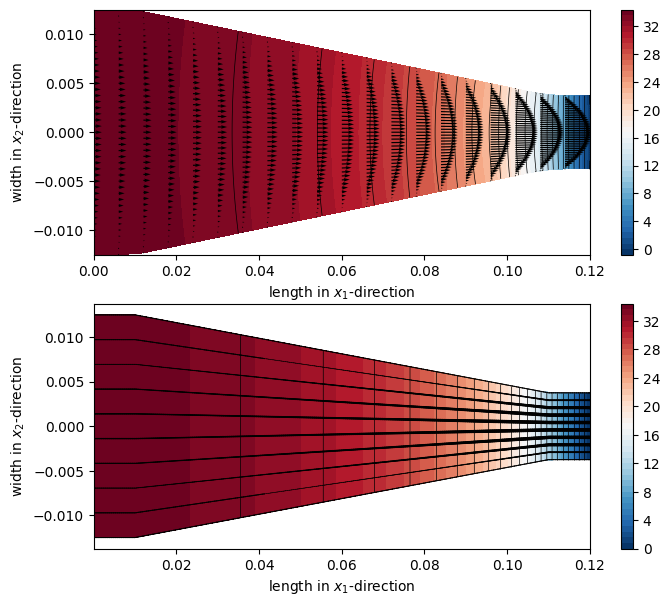

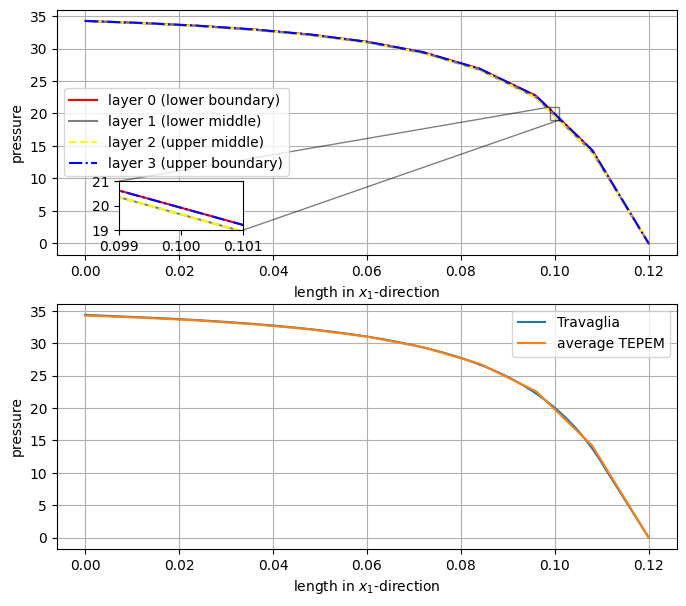

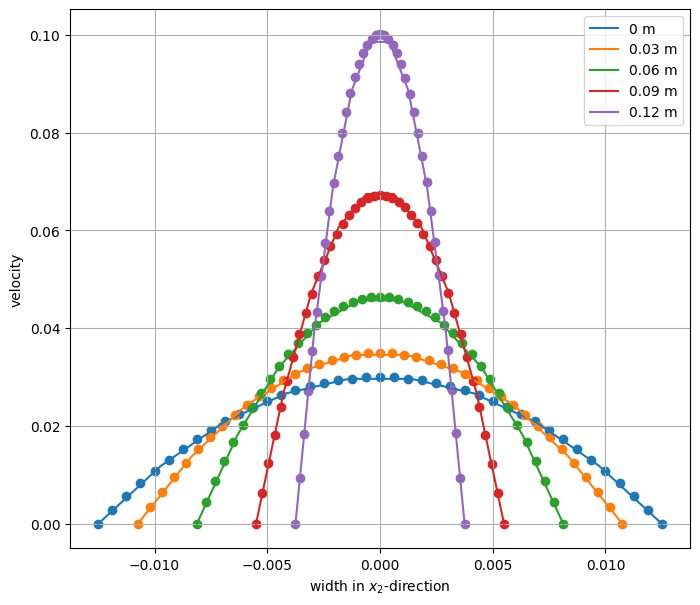

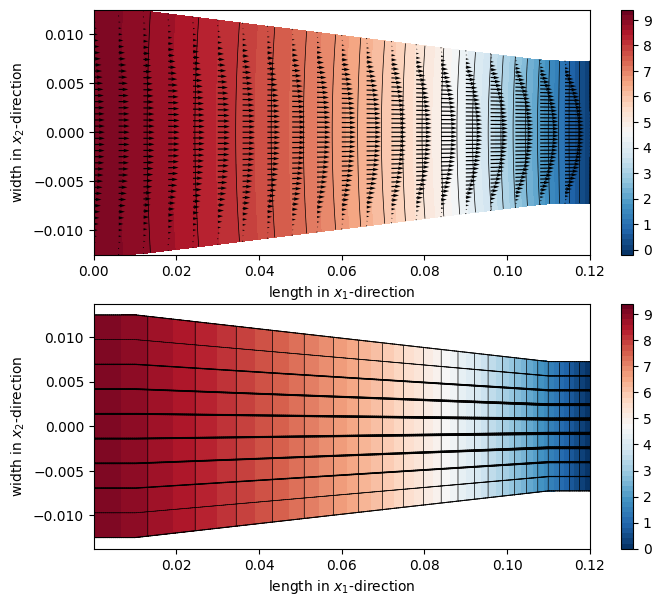

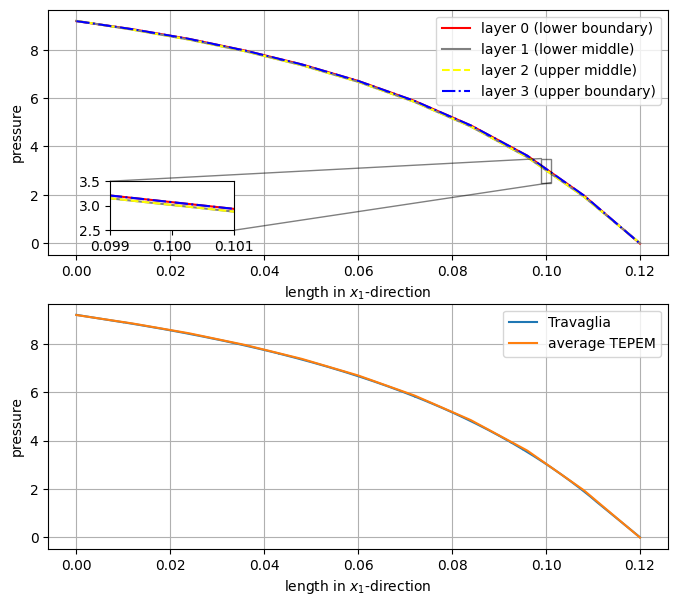

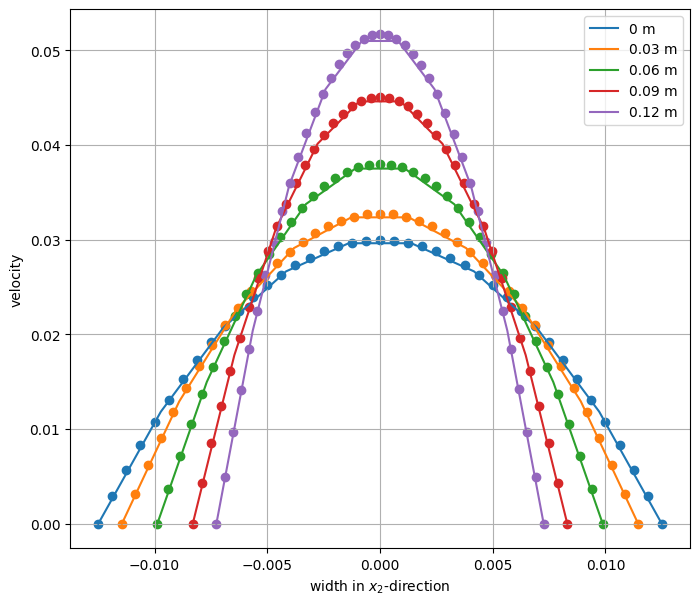

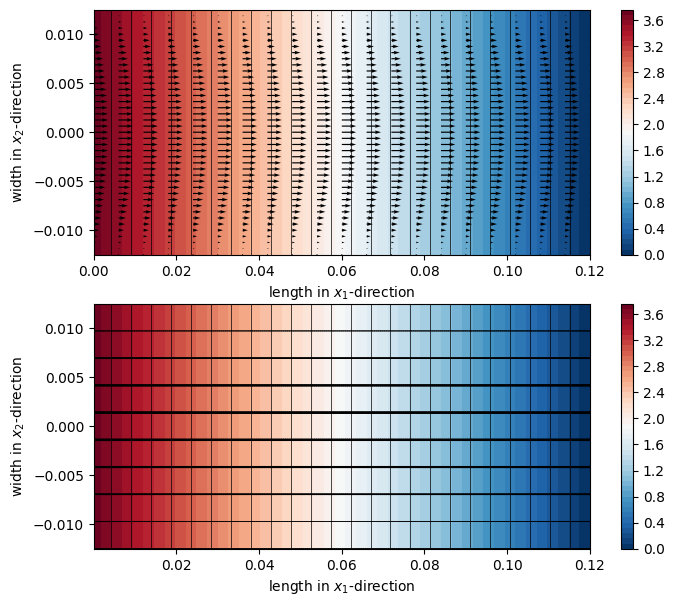

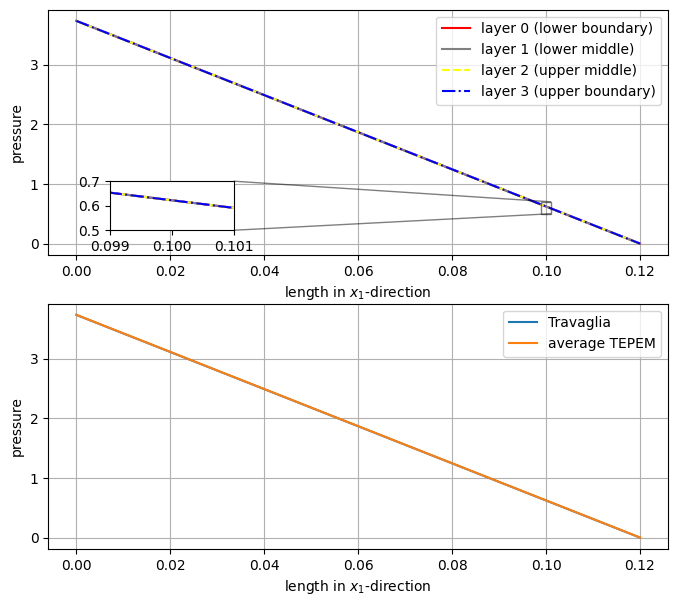

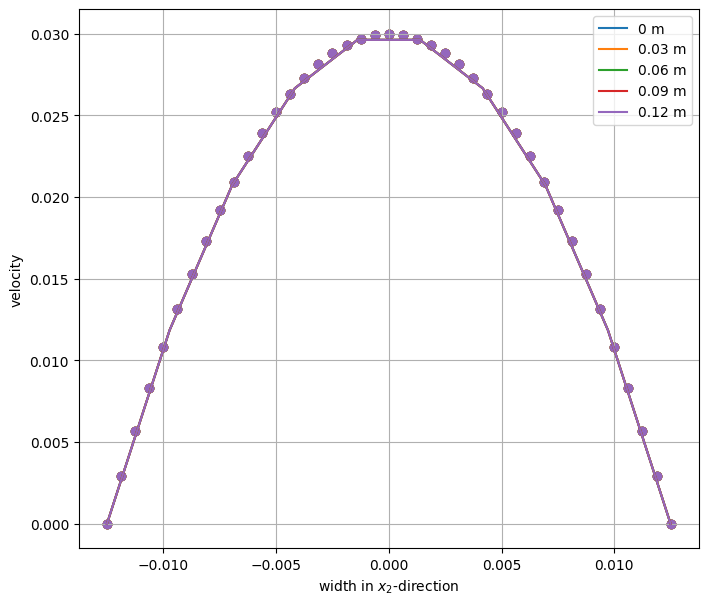

In [33]:

# %matplotlib widget
%matplotlib inline

plot_all_comparisons()